# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220201.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [7]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [8]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [9]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
# simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

In [10]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = 1000 * posterior/posterior.sum()

# run_prob_weekly(simulate_prob_freq)

In [11]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,4833.000,1369.000,5249.000,11451.0


3.0
[1. 1. 1.]
[1. 1. 1.]


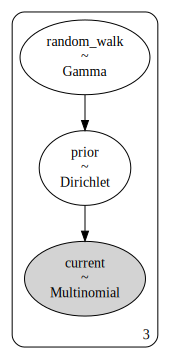

In [12]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    N = observed.sum() if not np.all(np.isnan(observed)) else 1_000
    print(N)
    print(prior)
    print(observed)
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=N, p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [13]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

## MONTHLY

In [14]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    rw_alpha_mult=1.0; rw_beta_mult=0.5
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=rw_alpha_mult, rw_beta_mult=rw_beta_mult)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [ ]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],8043.212,109.982,7826.235,8247.255,1.915,1.355,3296.0,2879.0,1.0
random_walk[1],2192.336,52.397,2093.950,2290.834,0.981,0.695,2867.0,2248.0,1.0
random_walk[2],8664.255,114.603,8452.478,8879.798,1.984,1.404,3336.0,3006.0,1.0
prior[0],0.424,0.004,0.417,0.431,0.000,0.000,2819.0,2416.0,1.0
prior[1],0.117,0.002,0.113,0.122,0.000,0.000,2481.0,2723.0,1.0
prior[2],0.458,0.004,0.451,0.465,0.000,0.000,3952.0,3314.0,1.0


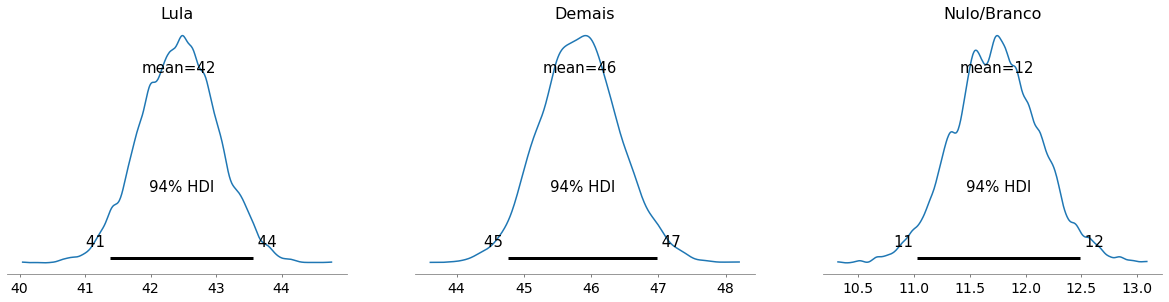

In [ ]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

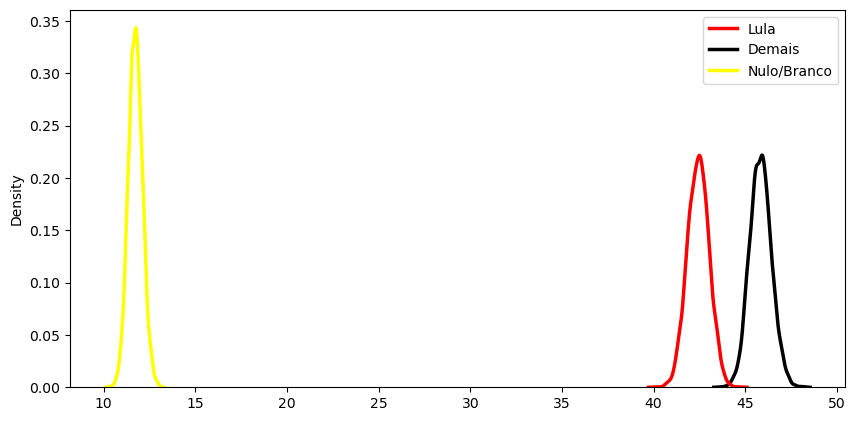

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [ ]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.0008

### Weekly update

In [ ]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    
    model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    #model_w = build_model(prior, observed, rw_alpha_mult=2, rw_beta_mult=1.0)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    
    qs = calc_prob_lula_win(model_w, trace_w, ppc=ppc_w)
    
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880 440 660]
1980
[400. 130. 470.]
[880 440 660]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[618.28278698 238.85136821 632.05152415],  qs=[33.3425 34.14   34.8425]% <<<
lula= [0.38988636 0.41515152 0.43939394]
nulo= [0.14191919 0.16060606 0.17929293]
demais= [0.39949495 0.42424242 0.45050505]
>>> observed = [990 288 783]
2061
[618.28278698 238.85136821 632.05152415]
[990 288 783]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[716.73447206 256.79821211 684.53712564],  qs=[79.2575 79.84   80.4525]% <<<
lula= [0.40902475 0.43231441 0.45608928]
nulo= [0.13828239 0.15477923 0.17273168]
demais= [0.38913149 0.41290636 0.43619602]
>>> observed = [ 704  270 1044]
2018
[716.73447206 256.79821211 684.53712564]
[ 704  270 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[680.21707214 247.42123289 720.55473109],  qs=[13.58  14.18  14.645]% <<<
lula= [0.38949455 0.41278494 0.43805748]
nulo= [0.13280476 0.15014866 0.16749257]
demais= [0.41328048 0.43756194 0.46134787]
>>> observed = [ 740  142 1118]
2000
[680.21707214 247.42123289 720.55473109]
[ 740  142 1118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[645.53200803 211.36589801 745.85239525],  qs=[0.2275 0.33   0.4525]% <<<
lula= [0.3785    0.4025    0.4270125]
nulo= [0.116  0.132  0.1485]
demais= [0.4405 0.4655 0.4895]
>>> observed = [ 850  225 1400]
2475
[645.53200803 211.36589801 745.85239525]
[ 850  225 1400]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[737.26945398 230.11919086 941.95949238],  qs=[0. 0. 0.]% <<<
lula= [0.3640404  0.38585859 0.40808081]
nulo= [0.10626263 0.12040404 0.13536364]
demais= [0.47070707 0.49333333 0.5159596 ]
>>> observed = [1883  140 2376]
4399
[737.26945398 230.11919086 941.95949238]
[1883  140 2376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1306.85621287  284.72022658 1662.10421948],  qs=[0. 0. 0.]% <<<
lula= [0.3848602  0.4016822  0.41873153]
nulo= [0.07774494 0.08751989 0.09729484]
demais= [0.49352125 0.51102523 0.52784724]
>>> observed = [937 244 855]
2036
[1306.85621287  284.72022658 1662.10421948]
[937 244 855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[725.27694407 162.59208422 881.62355805],  qs=[0.   0.   0.02]% <<<
lula= [0.3870334  0.40962672 0.4327112 ]
nulo= [0.07858546 0.09184676 0.10559921]
demais= [0.47544204 0.49852652 0.52062868]
>>> observed = [444 156 600]
1200
[725.27694407 162.59208422 881.62355805]
[444 156 600]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[427.07619911 102.7699609  526.26354953],  qs=[0.03 0.07 0.11]% <<<
lula= [0.37416667 0.40416667 0.435     ]
nulo= [0.08       0.09666667 0.11583333]
demais= [0.4675     0.49833333 0.52833333]
>>> observed = [856 306 838]
2000
[427.07619911 102.7699609  526.26354953]
[856 306 838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[630.03615695 175.75530705 723.40079865],  qs=[0.4375 0.57   0.74  ]% <<<
lula= [0.3875 0.412  0.437 ]
nulo= [0.0995 0.115  0.1315]
demais= [0.447  0.473  0.4985]
>>> observed = [ 758  170 1072]
2000
[630.03615695 175.75530705 723.40079865]
[ 758  170 1072]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[652.0622117  173.71690579 789.25738132],  qs=[0.    0.01  0.045]% <<<
lula= [0.38   0.404  0.4275]
nulo= [0.093  0.1075 0.1225]
demais= [0.4645 0.4885 0.513 ]
>>> observed = [960 280 760]
2000
[652.0622117  173.71690579 789.25738132]
[960 280 760]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[684.78960619 187.24051217 750.67958775],  qs=[3.535 3.83  4.13 ]% <<<
lula= [0.3975    0.422     0.4455125]
nulo= [0.1    0.115  0.1315]
demais= [0.4385 0.4625 0.487 ]
>>> observed = [1759  366 1539]
3664
[684.78960619 187.24051217 750.67958775]
[1759  366 1539]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8816239925289991, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[1192.00735831  294.81530238 1202.88942303],  qs=[40.2725 41.14   41.8725]% <<<
lula= [0.42467249 0.44295852 0.46233624]
nulo= [0.09797353 0.10944323 0.12117904]
demais= [0.42875955 0.4470524  0.46561135]
>>> observed = [440 120 450]
1010
[1192.00735831  294.81530238 1202.88942303]
[440 120 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[413.37844736 102.99286552 417.51576763],  qs=[43.1925 43.63   44.19  ]% <<<
lula= [0.41188119 0.44257426 0.47425743]
nulo= [0.09108911 0.10990099 0.13069307]
demais= [0.41485149 0.44752475 0.47821782]
>>> observed = [1200  330 1470]
3000
[413.37844736 102.99286552 417.51576763]
[1200  330 1470]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[895.71365919 233.15718513 985.97540407],  qs=[1.575 1.95  2.06 ]% <<<
lula= [0.40233333 0.42366667 0.44433333]
nulo= [0.097      0.11033333 0.12366667]
demais= [0.44533333 0.466      0.48766667]
>>> observed = [900 240 820]
1960
[895.71365919 233.15718513 985.97540407]
[900 240 820]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8846457397642223, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[695.15167695 181.84090349 738.13325097],  qs=[11.33   12.     12.6225]% <<<
lula= [0.40663265 0.43010204 0.45459184]
nulo= [0.09744898 0.1127551  0.12806122]
demais= [0.43214286 0.45714286 0.48061224]
>>> observed = [440 130 450]
1020
[695.15167695 181.84090349 738.13325097]
[440 130 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[375.16082972 100.0148088  395.75263127],  qs=[20.8675 21.6    22.1775]% <<<
lula= [0.39803922 0.43039216 0.46372549]
nulo= [0.09411765 0.11470588 0.13627451]
demais= [0.42058824 0.45392157 0.4872549 ]
>>> observed = [615 165 705]
1485
[375.16082972 100.0148088  395.75263127]
[615 165 705]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[481.04091645 128.77683109 519.95988589],  qs=[ 9.8475 10.5    10.8125]% <<<
lula= [0.3973064  0.42558923 0.45521886]
nulo= [0.0956229  0.11380471 0.13333333]
demais= [0.431633   0.46060606 0.48888889]
>>> observed = [1260  360 1350]
2970
[481.04091645 128.77683109 519.95988589]
[1260  360 1350]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-18, updaed_prior=[908.83875649 249.48224867 978.14421987],  qs=[4.8875 5.25   5.6   ]% <<<
lula= [0.4040404  0.42525253 0.44646465]
nulo= [0.1030303  0.11683502 0.13030303]
demais= [0.43702862 0.45791246 0.47912458]
>>> observed = [ 738  214 1044]
1996
[908.83875649 249.48224867 978.14421987]
[ 738  214 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8788394885761138, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-21, updaed_prior=[688.50857287 190.58975384 780.54746254],  qs=[0.5975 0.76   0.94  ]% <<<
lula= [0.39178357 0.41482966 0.43887776]
nulo= [0.0991984  0.11472946 0.13026052]
demais= [0.44639279 0.47044088 0.49398798]
>>> observed = [880 260 880]
2020
[688.50857287 190.58975384 780.54746254]
[880 260 880]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-25, updaed_prior=[681.09186423 191.64157874 750.18119805],  qs=[2.92   3.25   3.4525]% <<<
lula= [0.39554455 0.41980198 0.44257426]
nulo= [0.10295792 0.11782178 0.13415842]
demais= [0.43811881 0.46188119 0.48712871]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389886,0.415152,0.439394,0.399495,0.424242,0.450505
0,2021-11-06,0.409025,0.432314,0.456089,0.389131,0.412906,0.436196
0,2021-11-19,0.389495,0.412785,0.438057,0.413280,0.437562,0.461348
0,2021-11-20,0.378500,0.402500,0.427012,0.440500,0.465500,0.489500
0,2021-11-24,0.364040,0.385859,0.408081,0.470707,0.493333,0.515960
0,2021-11-29,0.384860,0.401682,0.418732,0.493521,0.511025,0.527847
0,2021-12-05,0.387033,0.409627,0.432711,0.475442,0.498527,0.520629
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.498333,0.528333
0,2021-12-11,0.387500,0.412000,0.437000,0.447000,0.473000,0.498500
0,2021-12-13,0.380000,0.404000,0.427500,0.464500,0.488500,0.513000


model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [ ]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [ ]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],6932.048,99.642,6751.787,7118.796,1.805,1.277,3047.0,2720.0,1.0
random_walk[1],1937.906,51.816,1837.377,2035.054,1.037,0.734,2490.0,2912.0,1.0
random_walk[2],7724.335,105.052,7535.996,7925.925,1.800,1.273,3372.0,2411.0,1.0
prior[0],0.420,0.005,0.410,0.429,0.000,0.000,2453.0,2888.0,1.0
prior[1],0.118,0.004,0.112,0.125,0.000,0.000,2077.0,2556.0,1.0
prior[2],0.462,0.005,0.453,0.472,0.000,0.000,3218.0,3016.0,1.0


In [ ]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

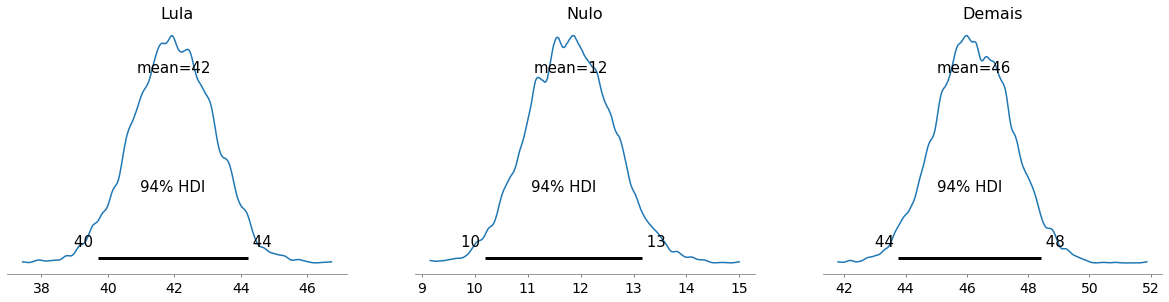

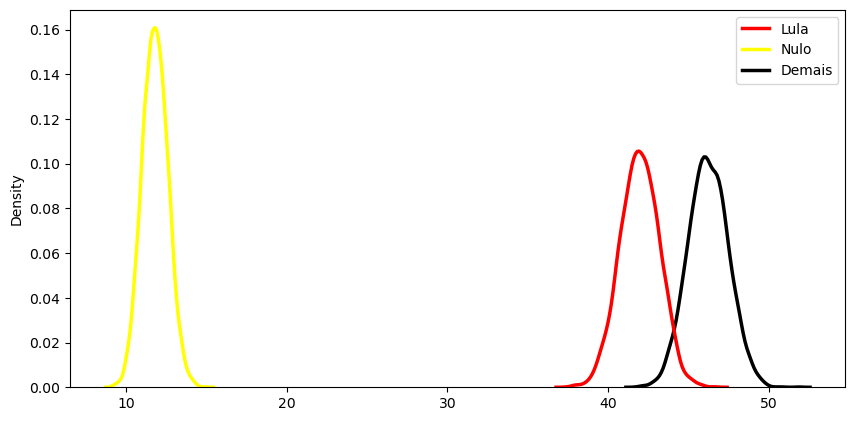

In [ ]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [ ]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389886,0.415152,0.439394,0.399495,0.424242,0.450505
0,2021-11-06,0.409025,0.432314,0.456089,0.389131,0.412906,0.436196
0,2021-11-19,0.389495,0.412785,0.438057,0.413280,0.437562,0.461348
0,2021-11-20,0.378500,0.402500,0.427012,0.440500,0.465500,0.489500
0,2021-11-24,0.364040,0.385859,0.408081,0.470707,0.493333,0.515960
0,2021-11-29,0.384860,0.401682,0.418732,0.493521,0.511025,0.527847
0,2021-12-05,0.387033,0.409627,0.432711,0.475442,0.498527,0.520629
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.498333,0.528333
0,2021-12-11,0.387500,0.412000,0.437000,0.447000,0.473000,0.498500
0,2021-12-13,0.380000,0.404000,0.427500,0.464500,0.488500,0.513000


In [ ]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()

for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3035.97413194  762.82434988 3691.55505965],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39392114 0.40533574 0.41641561]
nulo= [0.09519984 0.10176073 0.10879193]
demais= [0.48155419 0.49287005 0.50438508]
>>> observed = [7356 1973 7586]
16915
[3035.97413194  762.82434988 3691.55505965]
[7356 1973 7586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[3913.64137647 1036.05067684 4158.56370364],  qs=['0.235%', '0.3%', '0.38749999999999996%'] <<<
lula= [0.41944871 0.4296778  0.43984629]
nulo= [0.10747857 0.1137452  0.12030742]
demais= [0.44676323 0.456577   0.4671608 ]
>>> observed = [4833 1369 5249]
11451
[3913.64137647 1036.05067684 4158.56370364]
[4833 1369 5249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2795.1346513   777.44318924 3018.81304709],  qs=['0.0925%', '0.16%', '0.2175%'] <<<
lula= [0.41219108 0.42398044 0.43620644]
nulo= [0.11003406 0.11798096 0.12575321]
demais= [0.44624705 0.45795127 0.46982796]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [ ]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],3889.471,55.841,3785.349,3994.955,0.980,0.693,3237.0,2824.0,1.0
random_walk[1],1054.585,27.566,1003.282,1104.933,0.476,0.336,3313.0,2678.0,1.0
random_walk[2],4165.549,58.434,4057.802,4277.754,1.002,0.709,3393.0,2826.0,1.0
prior[0],0.424,0.004,0.417,0.432,0.000,0.000,3328.0,3316.0,1.0
prior[1],0.118,0.003,0.113,0.123,0.000,0.000,2643.0,2771.0,1.0
prior[2],0.458,0.004,0.450,0.465,0.000,0.000,4149.0,3625.0,1.0


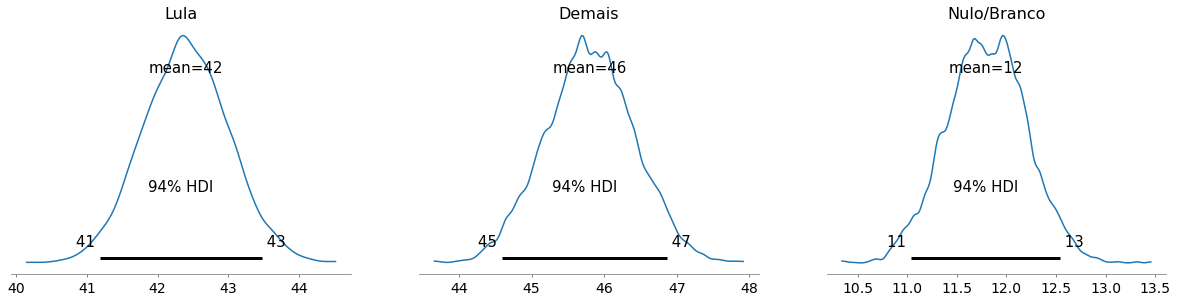

In [ ]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

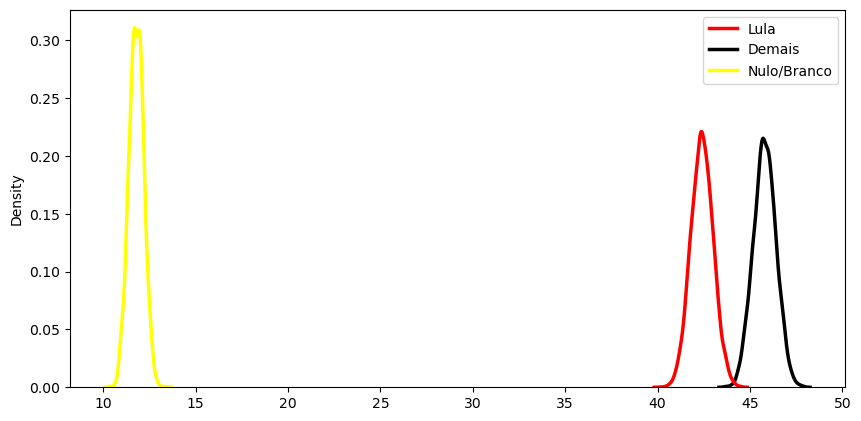

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [ ]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.0018

### DAILY

In [ ]:
# for obj in df.itertuples():
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [ ]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)
print(n_days)
print(poll_day.shape)

83
(20,)


In [ ]:
# prior = np.array([435, 110, 455]) 
to_predict = np.zeros((n_days, 3)) * np.nan

to_predict[poll_day,:] = np.array([df.LULA, df.NULO, df.OUTROS]).astype("int32").T

flat_prior = prior = np.array([400.0, 130.0, 470.0])

df_results_daily = pd.DataFrame({})
day = -1
for obj in to_predict:
    day += 1
    observed = np.array([obj[0], obj[1], obj[2]])
    print(f">>> observed = {observed}")
    
    model_d = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    trace_d, ppc_d = sampling(model_d)
    posterior_d = ppc_d['current']
    
    prior = dirichlet.mle(posterior_d/posterior_d.sum(axis=1).reshape(-1, 1))
    
    #qs = calc_prob_lula_win(model_d, trace_d, ppc=ppc_d)
    
    print(f">>> data_pesquisa={day}, updaed_prior={prior} <<<");
    post_prob = posterior_d/posterior_d.sum(axis=1).reshape(-1, 1)
    df_results_daily = df_results_daily.append(pd.DataFrame({"data":[day],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_daily



>>> observed = [880. 440. 660.]
1980.0
[400. 130. 470.]
[880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=0, updaed_prior=[641.41289995 247.42179842 656.25378419] <<<
lula= [0.39040404 0.41515152 0.43939394]
nulo= [0.14191919 0.16010101 0.17878788]
demais= [0.4        0.42474747 0.4489899 ]
>>> observed = [nan nan nan]
1000
[641.41289995 247.42179842 656.25378419]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=1, updaed_prior=[358.07966756 138.35037107 362.72393711] <<<
lula= [0.384 0.417 0.45 ]
nulo= [0.137 0.161 0.186]
demais= [0.389975 0.422    0.455   ]
>>> observed = [990. 288. 783.]
2061.0
[358.07966756 138.35037107 362.72393711]
[990. 288. 783.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=2, updaed_prior=[667.1726108  231.82874545 615.53173293] <<<
lula= [0.41629064 0.44056283 0.4648229 ]
nulo= [0.13537118 0.15283843 0.17127608]
demais= [0.38136827 0.40659874 0.43182921]
>>> observed = [nan nan nan]
1000
[667.1726108  231.82874545 615.53173293]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=3, updaed_prior=[375.68776535 129.80817583 347.70100022] <<<
lula= [0.407 0.44  0.473]
nulo= [0.128 0.152 0.178]
demais= [0.375 0.408 0.439]
>>> observed = [nan nan nan]
1000
[375.68776535 129.80817583 347.70100022]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=4, updaed_prior=[354.8218999  123.67617852 327.58917285] <<<
lula= [0.405 0.441 0.474]
nulo= [0.129 0.153 0.179]
demais= [0.373 0.406 0.44 ]
>>> observed = [nan nan nan]
1000
[354.8218999  123.67617852 327.58917285]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=5, updaed_prior=[325.92765787 115.38383182 303.75839574] <<<
lula= [0.402 0.437 0.474]
nulo= [0.13  0.155 0.181]
demais= [0.372 0.408 0.443]
>>> observed = [nan nan nan]
1000
[325.92765787 115.38383182 303.75839574]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=6, updaed_prior=[335.12331784 119.28879072 313.12794777] <<<
lula= [0.402 0.437 0.472]
nulo= [0.13  0.155 0.181]
demais= [0.374 0.408 0.443]
>>> observed = [nan nan nan]
1000
[335.12331784 119.28879072 313.12794777]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=7, updaed_prior=[348.26634707 122.55056703 325.98064931] <<<
lula= [0.404 0.437 0.472]
nulo= [0.129 0.154 0.179]
demais= [0.376 0.409 0.443]
>>> observed = [nan nan nan]
1000
[348.26634707 122.55056703 325.98064931]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=8, updaed_prior=[359.60693461 123.64576729 337.95123606] <<<
lula= [0.405 0.438 0.471]
nulo= [0.126 0.151 0.175]
demais= [0.378 0.412 0.445]
>>> observed = [nan nan nan]
1000
[359.60693461 123.64576729 337.95123606]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=9, updaed_prior=[348.2335475  120.21243025 324.44280481] <<<
lula= [0.404 0.439 0.473]
nulo= [0.128 0.151 0.177]
demais= [0.374975 0.409    0.444   ]
>>> observed = [nan nan nan]
1000
[348.2335475  120.21243025 324.44280481]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=10, updaed_prior=[329.79149261 113.87208652 308.06693203] <<<
lula= [0.404 0.438 0.475]
nulo= [0.126 0.151 0.178]
demais= [0.374975 0.41     0.444   ]
>>> observed = [nan nan nan]
1000
[329.79149261 113.87208652 308.06693203]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=11, updaed_prior=[321.23323447 111.21072395 298.13793471] <<<
lula= [0.405 0.44  0.474]
nulo= [0.126 0.152 0.179]
demais= [0.374 0.408 0.443]
>>> observed = [nan nan nan]
1000
[321.23323447 111.21072395 298.13793471]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=12, updaed_prior=[334.17016015 116.71887903 311.18912834] <<<
lula= [0.404 0.438 0.474]
nulo= [0.128 0.153 0.179]
demais= [0.373 0.408 0.443]
>>> observed = [nan nan nan]
1000
[334.17016015 116.71887903 311.18912834]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=13, updaed_prior=[318.17212372 108.29361814 296.2013122 ] <<<
lula= [0.406 0.44  0.474]
nulo= [0.125 0.149 0.178]
demais= [0.375    0.41     0.445025]
>>> observed = [nan nan nan]
1000
[318.17212372 108.29361814 296.2013122 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=14, updaed_prior=[349.61184098 119.91625892 325.04650026] <<<
lula= [0.404 0.44  0.474]
nulo= [0.126 0.151 0.176]
demais= [0.376 0.409 0.444]
>>> observed = [ 704.  270. 1044.]
2018.0
[349.61184098 119.91625892 325.04650026]
[ 704.  270. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=15, updaed_prior=[567.3155335  201.95208839 631.93042126] <<<
lula= [0.37957136 0.40485629 0.43063677]
nulo= [0.1258672  0.14420218 0.16253717]
demais= [0.4246779  0.45094153 0.47720515]
>>> observed = [ 740.  142. 1118.]
2000.0
[567.3155335  201.95208839 631.93042126]
[ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=16, updaed_prior=[617.60726283 194.61771127 747.1827053 ] <<<
lula= [0.3725 0.396  0.4205]
nulo= [0.1085 0.1245 0.1425]
demais= [0.455  0.4795 0.5035]
>>> observed = [nan nan nan]
1000
[617.60726283 194.61771127 747.1827053 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=17, updaed_prior=[352.90034554 112.07165844 428.23558946] <<<
lula= [0.364 0.395 0.427]
nulo= [0.105 0.125 0.148]
demais= [0.446 0.479 0.512]
>>> observed = [nan nan nan]
1000
[352.90034554 112.07165844 428.23558946]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=18, updaed_prior=[312.85603748  98.902029   378.20548167] <<<
lula= [0.362 0.396 0.43 ]
nulo= [0.103 0.125 0.149]
demais= [0.444975 0.479    0.514   ]
>>> observed = [nan nan nan]
1000
[312.85603748  98.902029   378.20548167]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=19, updaed_prior=[308.73742184  99.55272939 369.731235  ] <<<
lula= [0.364    0.397    0.430025]
nulo= [0.105 0.127 0.153]
demais= [0.441 0.475 0.509]
>>> observed = [ 850.  225. 1400.]
2475.0
[308.73742184  99.55272939 369.731235  ]
[ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=20, updaed_prior=[651.72751525 194.94020279 899.87662003] <<<
lula= [0.35070707 0.37292929 0.39555556]
nulo= [0.09656566 0.11151515 0.12686869]
demais= [0.49212121 0.51515152 0.53818182]
>>> observed = [nan nan nan]
1000
[651.72751525 194.94020279 899.87662003]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=21, updaed_prior=[327.74497731  97.71436962 451.75097936] <<<
lula= [0.342 0.374 0.406]
nulo= [0.091 0.111 0.133]
demais= [0.483 0.515 0.549]
>>> observed = [nan nan nan]
1000
[327.74497731  97.71436962 451.75097936]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=22, updaed_prior=[288.98064598  84.93044053 393.82744484] <<<
lula= [0.342 0.376 0.412]
nulo= [0.09  0.11  0.133]
demais= [0.478 0.513 0.549]
>>> observed = [nan nan nan]
1000
[288.98064598  84.93044053 393.82744484]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=23, updaed_prior=[289.89428147  85.60442216 398.53148465] <<<
lula= [0.341 0.375 0.408]
nulo= [0.089 0.11  0.134]
demais= [0.48  0.515 0.55 ]
>>> observed = [nan nan nan]
1000
[289.89428147  85.60442216 398.53148465]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=24, updaed_prior=[297.83259313  89.69536237 408.2529369 ] <<<
lula= [0.341 0.374 0.408]
nulo= [0.091 0.112 0.136]
demais= [0.478 0.513 0.548]
>>> observed = [1883.  140. 2376.]
4399.0
[297.83259313  89.69536237 408.2529369 ]
[1883.  140. 2376.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=25, updaed_prior=[1100.63012586  174.47831854 1434.49914248] <<<
lula= [0.38781541 0.40611503 0.42441464]
nulo= [0.05546147 0.0643328  0.07410775]
demais= [0.51102523 0.52943851 0.54807911]
>>> observed = [nan nan nan]
1000
[1100.63012586  174.47831854 1434.49914248]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=26, updaed_prior=[372.36823682  59.06886975 485.93247743] <<<
lula= [0.374 0.406 0.437]
nulo= [0.049 0.064 0.081]
demais= [0.498 0.53  0.561]
>>> observed = [nan nan nan]
1000
[372.36823682  59.06886975 485.93247743]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=27, updaed_prior=[325.73226203  52.46873032 426.98290172] <<<
lula= [0.371 0.404 0.438]
nulo= [0.049 0.065 0.083]
demais= [0.496 0.53  0.564]
>>> observed = [nan nan nan]
1000
[325.73226203  52.46873032 426.98290172]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=28, updaed_prior=[315.62805326  51.08586972 415.49608429] <<<
lula= [0.37  0.404 0.436]
nulo= [0.048975 0.065    0.084   ]
demais= [0.498 0.531 0.565]
>>> observed = [nan nan nan]
1000
[315.62805326  51.08586972 415.49608429]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=29, updaed_prior=[308.27636089  49.87456634 394.92473577] <<<
lula= [0.375 0.409 0.444]
nulo= [0.049 0.066 0.085]
demais= [0.49  0.524 0.559]
>>> observed = [nan nan nan]
1000
[308.27636089  49.87456634 394.92473577]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=30, updaed_prior=[301.39084225  48.40679121 389.51855904] <<<
lula= [0.372 0.408 0.443]
nulo= [0.048 0.065 0.084]
demais= [0.492    0.527    0.562025]
>>> observed = [937. 244. 855.]
2036.0
[301.39084225  48.40679121 389.51855904]
[937. 244. 855.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=31, updaed_prior=[623.81937571 126.73801106 702.1073842 ] <<<
lula= [0.40373281 0.42976424 0.45433448]
nulo= [0.07318271 0.08693517 0.1021611 ]
demais= [0.45776031 0.48330059 0.50884086]
>>> observed = [nan nan nan]
1000
[623.81937571 126.73801106 702.1073842 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=32, updaed_prior=[372.58429187  77.34495627 421.66897881] <<<
lula= [0.395    0.427    0.459025]
nulo= [0.070975 0.089    0.108   ]
demais= [0.451 0.483 0.517]
>>> observed = [nan nan nan]
1000
[372.58429187  77.34495627 421.66897881]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=33, updaed_prior=[358.44340716  74.1368347  402.20844155] <<<
lula= [0.398 0.429 0.463]
nulo= [0.07  0.088 0.109]
demais= [0.448 0.482 0.515]
>>> observed = [nan nan nan]
1000
[358.44340716  74.1368347  402.20844155]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=34, updaed_prior=[338.91323927  68.94515763 381.09632431] <<<
lula= [0.395 0.43  0.465]
nulo= [0.069 0.087 0.108]
demais= [0.45  0.483 0.518]
>>> observed = [444. 156. 600.]
1200.0
[338.91323927  68.94515763 381.09632431]
[444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=35, updaed_prior=[389.89557348  93.57600614 460.66806977] <<<
lula= [0.38166667 0.41333333 0.44333333]
nulo= [0.08083333 0.09916667 0.11833333]
demais= [0.45666667 0.4875     0.52083333]
>>> observed = [nan nan nan]
1000
[389.89557348  93.57600614 460.66806977]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=36, updaed_prior=[332.88444038  78.98110874 387.09839965] <<<
lula= [0.383 0.416 0.451]
nulo= [0.078975 0.099    0.12    ]
demais= [0.45  0.484 0.518]
>>> observed = [856. 306. 838.]
2000.0
[332.88444038  78.98110874 387.09839965]
[856. 306. 838.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=37, updaed_prior=[593.22689177 168.11512412 647.14590372] <<<
lula= [0.395     0.4215    0.4465125]
nulo= [0.1025 0.119  0.1365]
demais= [0.4335 0.4595 0.486 ]
>>> observed = [nan nan nan]
1000
[593.22689177 168.11512412 647.14590372]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=38, updaed_prior=[362.18582552 103.64313199 396.45119156] <<<
lula= [0.387 0.42  0.453]
nulo= [0.099 0.12  0.142]
demais= [0.427 0.46  0.494]
>>> observed = [960. 280. 760.]
2000.0
[362.18582552 103.64313199 396.45119156]
[960. 280. 760.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=39, updaed_prior=[627.74468123 181.0067276  611.37438733] <<<
lula= [0.4159875 0.442     0.469    ]
nulo= [0.1109875 0.127     0.145    ]
demais= [0.4045 0.4305 0.456 ]
>>> observed = [nan nan nan]
1000
[627.74468123 181.0067276  611.37438733]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=40, updaed_prior=[372.68409298 104.74439296 363.07926163] <<<
lula= [0.411 0.443 0.478]
nulo= [0.102 0.124 0.148]
demais= [0.399 0.432 0.464]
>>> observed = [nan nan nan]
1000
[372.68409298 104.74439296 363.07926163]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=41, updaed_prior=[346.41734928  95.53795968 337.96628373] <<<
lula= [0.41  0.444 0.478]
nulo= [0.1   0.122 0.147]
demais= [0.399 0.433 0.467]
>>> observed = [440. 120. 450.]
1010.0
[346.41734928  95.53795968 337.96628373]
[440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=42, updaed_prior=[348.37022497  95.99337253 344.60044076] <<<
lula= [0.40693069 0.44158416 0.47527228]
nulo= [0.1        0.12178218 0.14455446]
demais= [0.4029703  0.43663366 0.47128713]
>>> observed = [nan nan nan]
1000
[348.37022497  95.99337253 344.60044076]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=43, updaed_prior=[344.36040401  91.89366354 340.54989886] <<<
lula= [0.408 0.443 0.478]
nulo= [0.096 0.118 0.142]
demais= [0.405 0.438 0.474]
>>> observed = [nan nan nan]
1000
[344.36040401  91.89366354 340.54989886]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=44, updaed_prior=[328.01348754  90.19556127 329.51691617] <<<
lula= [0.404    0.438    0.473025]
nulo= [0.097 0.12  0.145]
demais= [0.406 0.441 0.475]
>>> observed = [nan nan nan]
1000
[328.01348754  90.19556127 329.51691617]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=45, updaed_prior=[337.56123554  94.34039664 339.13316506] <<<
lula= [0.403 0.438 0.473]
nulo= [0.1   0.122 0.145]
demais= [0.405 0.44  0.475]
>>> observed = [nan nan nan]
1000
[337.56123554  94.34039664 339.13316506]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=46, updaed_prior=[345.25921147  94.5121498  339.47883924] <<<
lula= [0.407 0.443 0.478]
nulo= [0.099 0.121 0.145]
demais= [0.401 0.436 0.47 ]
>>> observed = [1200.  330. 1470.]
3000.0
[345.25921147  94.5121498  339.47883924]
[1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=47, updaed_prior=[831.74181509 228.03621841 911.30474765] <<<
lula= [0.39966667 0.422      0.444     ]
nulo= [0.10166667 0.11533333 0.13      ]
demais= [0.44099167 0.46233333 0.484     ]
>>> observed = [nan nan nan]
1000
[831.74181509 228.03621841 911.30474765]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=48, updaed_prior=[373.6865626  102.72527233 409.07204713] <<<
lula= [0.39  0.422 0.455]
nulo= [0.096 0.116 0.137]
demais= [0.428    0.462    0.495025]
>>> observed = [nan nan nan]
1000
[373.6865626  102.72527233 409.07204713]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=49, updaed_prior=[337.86615507  92.40250362 372.91738632] <<<
lula= [0.386 0.421 0.455]
nulo= [0.094 0.115 0.138]
demais= [0.43  0.465 0.498]
>>> observed = [nan nan nan]
1000
[337.86615507  92.40250362 372.91738632]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=50, updaed_prior=[324.7715663   90.2883957  354.15632032] <<<
lula= [0.388 0.422 0.457]
nulo= [0.095 0.117 0.141]
demais= [0.426 0.461 0.495]
>>> observed = [nan nan nan]
1000
[324.7715663   90.2883957  354.15632032]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=51, updaed_prior=[327.60061388  91.13905071 358.37879764] <<<
lula= [0.388 0.421 0.457]
nulo= [0.096 0.117 0.14 ]
demais= [0.426 0.461 0.496]
>>> observed = [nan nan nan]
1000
[327.60061388  91.13905071 358.37879764]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=52, updaed_prior=[329.71897216  92.03707704 368.3058905 ] <<<
lula= [0.384 0.417 0.452]
nulo= [0.095 0.116 0.139]
demais= [0.432 0.466 0.5  ]
>>> observed = [nan nan nan]
1000
[329.71897216  92.03707704 368.3058905 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=53, updaed_prior=[326.83761904  89.38057657 362.57730975] <<<
lula= [0.386 0.42  0.454]
nulo= [0.093 0.115 0.138]
demais= [0.431 0.465 0.501]
>>> observed = [nan nan nan]
1000
[326.83761904  89.38057657 362.57730975]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=54, updaed_prior=[324.66609002  88.80356638 352.80324917] <<<
lula= [0.39  0.423 0.459]
nulo= [0.094 0.116 0.14 ]
demais= [0.425 0.46  0.495]
>>> observed = [nan nan nan]
1000
[324.66609002  88.80356638 352.80324917]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=55, updaed_prior=[333.57038766  90.65033217 360.24489588] <<<
lula= [0.391 0.425 0.459]
nulo= [0.094 0.115 0.139]
demais= [0.425975 0.459    0.493025]
>>> observed = [nan nan nan]
1000
[333.57038766  90.65033217 360.24489588]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=56, updaed_prior=[335.20397381  91.24754597 363.02409145] <<<
lula= [0.39  0.425 0.459]
nulo= [0.094 0.116 0.138]
demais= [0.424 0.46  0.494]
>>> observed = [nan nan nan]
1000
[335.20397381  91.24754597 363.02409145]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=57, updaed_prior=[331.25772968  90.69957709 363.59037191] <<<
lula= [0.386 0.422 0.456]
nulo= [0.094 0.115 0.138]
demais= [0.427 0.463 0.498]
>>> observed = [nan nan nan]
1000
[331.25772968  90.69957709 363.59037191]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=58, updaed_prior=[322.61177682  88.39222325 352.53104372] <<<
lula= [0.388 0.423 0.458]
nulo= [0.093 0.116 0.139]
demais= [0.427 0.462 0.497]
>>> observed = [nan nan nan]
1000
[322.61177682  88.39222325 352.53104372]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=59, updaed_prior=[329.34447696  90.44105261 362.28281964] <<<
lula= [0.388 0.421 0.455]
nulo= [0.093 0.115 0.14 ]
demais= [0.428 0.463 0.497]
>>> observed = [nan nan nan]
1000
[329.34447696  90.44105261 362.28281964]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=60, updaed_prior=[324.10967742  90.30529631 359.36315399] <<<
lula= [0.384 0.419 0.454]
nulo= [0.095 0.117 0.14 ]
demais= [0.43  0.464 0.499]
>>> observed = [nan nan nan]
1000
[324.10967742  90.30529631 359.36315399]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=61, updaed_prior=[327.61862289  89.78329865 360.91549405] <<<
lula= [0.387 0.421 0.456]
nulo= [0.093 0.115 0.138]
demais= [0.428 0.464 0.498]
>>> observed = [nan nan nan]
1000
[327.61862289  89.78329865 360.91549405]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=62, updaed_prior=[334.84227206  93.72496042 368.31676805] <<<
lula= [0.385 0.42  0.455]
nulo= [0.095975 0.118    0.14    ]
demais= [0.428 0.462 0.497]
>>> observed = [nan nan nan]
1000
[334.84227206  93.72496042 368.31676805]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=63, updaed_prior=[330.30080792  93.10015084 359.11432209] <<<
lula= [0.387 0.422 0.456]
nulo= [0.097    0.119    0.142025]
demais= [0.424 0.459 0.494]
>>> observed = [nan nan nan]
1000
[330.30080792  93.10015084 359.11432209]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.7013322775014451, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=64, updaed_prior=[326.32958787  92.35061117 356.62714187] <<<
lula= [0.387 0.421 0.455]
nulo= [0.097 0.119 0.142]
demais= [0.426 0.46  0.494]
>>> observed = [nan nan nan]
1000
[326.32958787  92.35061117 356.62714187]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=65, updaed_prior=[335.1259342   93.2319152  359.92520592] <<<
lula= [0.391 0.425 0.46 ]
nulo= [0.097 0.118 0.141]
demais= [0.421 0.457 0.492]
>>> observed = [900. 240. 820.]
1960.0
[335.1259342   93.2319152  359.92520592]
[900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=66, updaed_prior=[622.57917149 170.25532497 627.86883893] <<<
lula= [0.41326531 0.4377551  0.46377551]
nulo= [0.10357143 0.11989796 0.13725765]
demais= [0.41581633 0.44183673 0.46734694]
>>> observed = [nan nan nan]
1000
[622.57917149 170.25532497 627.86883893]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=67, updaed_prior=[379.57031309 102.90144038 377.3728608 ] <<<
lula= [0.408 0.442 0.476]
nulo= [0.098    0.119    0.141025]
demais= [0.407 0.439 0.473]
>>> observed = [nan nan nan]
1000
[379.57031309 102.90144038 377.3728608 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=68, updaed_prior=[352.60619789  94.46471486 350.30669373] <<<
lula= [0.408 0.442 0.477]
nulo= [0.096 0.118 0.141]
demais= [0.406 0.44  0.474]
>>> observed = [440. 130. 450.]
1020.0
[352.60619789  94.46471486 350.30669373]
[440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=69, updaed_prior=[347.14432987  95.17354239 347.33383587] <<<
lula= [0.40588235 0.44019608 0.47355392]
nulo= [0.09803922 0.12058824 0.14411765]
demais= [0.40490196 0.43921569 0.4745098 ]
>>> observed = [615. 165. 705.]
1485.0
[347.14432987  95.17354239 347.33383587]
[615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=70, updaed_prior=[485.26665996 132.01818689 507.44340901] <<<
lula= [0.4020202  0.43164983 0.46060606]
nulo= [0.0989899  0.11717172 0.13602694]
demais= [0.42154882 0.45117845 0.48013468]
>>> observed = [nan nan nan]
1000
[485.26665996 132.01818689 507.44340901]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=71, updaed_prior=[354.011225    97.35972258 371.85862267] <<<
lula= [0.396 0.43  0.464]
nulo= [0.097 0.118 0.14 ]
demais= [0.418 0.452 0.486]
>>> observed = [nan nan nan]
1000
[354.011225    97.35972258 371.85862267]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=72, updaed_prior=[342.58139709  93.33527202 359.86008407] <<<
lula= [0.397 0.43  0.465]
nulo= [0.095    0.117    0.140025]
demais= [0.418 0.452 0.486]
>>> observed = [nan nan nan]
1000
[342.58139709  93.33527202 359.86008407]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=73, updaed_prior=[336.11042244  90.75844777 351.89946039] <<<
lula= [0.398 0.431 0.466]
nulo= [0.094 0.117 0.139]
demais= [0.417 0.452 0.486]
>>> observed = [nan nan nan]
1000
[336.11042244  90.75844777 351.89946039]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=74, updaed_prior=[325.45106633  87.16854042 340.90157178] <<<
lula= [0.397 0.432 0.469]
nulo= [0.093 0.115 0.139]
demais= [0.418    0.452    0.487025]
>>> observed = [1260.  360. 1350.]
2970.0
[325.45106633  87.16854042 340.90157178]
[1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=75, updaed_prior=[855.6997931  236.81971571 906.56651917] <<<
lula= [0.40707071 0.42794613 0.44983165]
nulo= [0.1047138  0.11818182 0.13265993]
demais= [0.43164983 0.45353535 0.47441077]
>>> observed = [nan nan nan]
1000
[855.6997931  236.81971571 906.56651917]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=76, updaed_prior=[389.85733335 107.66064487 414.63733126] <<<
lula= [0.396 0.427 0.46 ]
nulo= [0.098 0.118 0.139]
demais= [0.423 0.454 0.487]
>>> observed = [nan nan nan]
1000
[389.85733335 107.66064487 414.63733126]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=77, updaed_prior=[345.29681221  94.92234642 367.49799669] <<<
lula= [0.393 0.427 0.462]
nulo= [0.096 0.117 0.14 ]
demais= [0.42  0.455 0.489]
>>> observed = [ 738.  214. 1044.]
1996.0
[345.29681221  94.92234642 367.49799669]
[ 738.  214. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=78, updaed_prior=[583.62838696 163.69059251 692.09155878] <<<
lula= [0.38126253 0.40531062 0.43086172]
nulo= [0.09769539 0.11372745 0.13026052]
demais= [0.45440882 0.48096192 0.50551102]
>>> observed = [nan nan nan]
1000
[583.62838696 163.69059251 692.09155878]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=79, updaed_prior=[347.55131149  96.39188082 413.06435312] <<<
lula= [0.373 0.406 0.439]
nulo= [0.092 0.112 0.135]
demais= [0.449 0.482 0.516]
>>> observed = [nan nan nan]
1000
[347.55131149  96.39188082 413.06435312]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=80, updaed_prior=[322.24195402  90.49597144 376.46047324] <<<
lula= [0.374 0.408 0.443]
nulo= [0.093 0.114 0.138]
demais= [0.442 0.477 0.511]
>>> observed = [nan nan nan]
1000
[322.24195402  90.49597144 376.46047324]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=81, updaed_prior=[307.35170737  88.41978773 359.27998258] <<<
lula= [0.372 0.407 0.443]
nulo= [0.094 0.117 0.141]
demais= [0.44  0.476 0.511]
>>> observed = [880. 260. 880.]
2020.0
[307.35170737  88.41978773 359.27998258]
[880. 260. 880.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=82, updaed_prior=[611.40658199 177.67741722 671.95615737] <<<
lula= [0.39355198 0.41881188 0.44407178]
nulo= [0.1049505  0.12128713 0.14009901]
demais= [0.43465347 0.45990099 0.48514851]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,0,0.390404,0.415152,0.439394,0.400000,0.424747,0.448990
0,1,0.384000,0.417000,0.450000,0.389975,0.422000,0.455000
0,2,0.416291,0.440563,0.464823,0.381368,0.406599,0.431829
0,3,0.407000,0.440000,0.473000,0.375000,0.408000,0.439000
0,4,0.405000,0.441000,0.474000,0.373000,0.406000,0.440000
0,5,0.402000,0.437000,0.474000,0.372000,0.408000,0.443000
0,6,0.402000,0.437000,0.472000,0.374000,0.408000,0.443000
0,7,0.404000,0.437000,0.472000,0.376000,0.409000,0.443000
0,8,0.405000,0.438000,0.471000,0.378000,0.412000,0.445000
0,9,0.404000,0.439000,0.473000,0.374975,0.409000,0.444000


In [ ]:
trace_d, ppc_d = sampling(model_d)
posterior_d = ppc_d['current']
az.summary(trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],3123.419,62.161,3015.675,3247.271,1.037,0.734,3582.0,2486.0,1.0
random_walk[1],905.412,34.240,843.037,968.859,0.630,0.446,2942.0,2603.0,1.0
random_walk[2],3520.527,67.727,3386.103,3641.858,1.149,0.812,3476.0,2410.0,1.0
prior[0],0.418,0.007,0.404,0.430,0.000,0.000,2934.0,2835.0,1.0
prior[1],0.122,0.005,0.113,0.132,0.000,0.000,2201.0,2454.0,1.0
prior[2],0.460,0.007,0.446,0.472,0.000,0.000,3646.0,3088.0,1.0


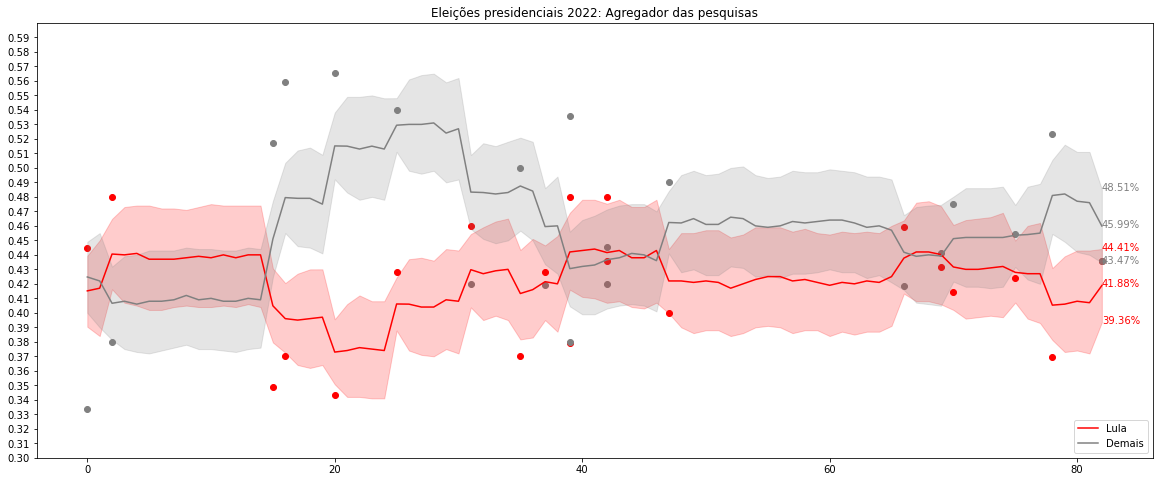

In [ ]:
dfrw = df_results_daily.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(dfrw.data[poll_day], df.LULA/df.TOTAL, color='red')
plt.scatter(dfrw.data[poll_day], df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

## Playground

In [ ]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [ ]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [ ]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

# df_gm = px.data.gapminder()
# px.scatter(df_gm, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

[[0.51890781 0.14037439 0.34071781]
 [0.387207   0.11195887 0.50083412]
 [0.43735379 0.07976993 0.48287628]
 [0.43100986 0.11120549 0.45778465]]


In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


0.42725
(4000, 3)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

[1180.38900274 1198.87849203 1248.58339571 ... 1179.74518152 1213.47277332
 1213.56059029]
[690.66629015 507.24117335 570.30933925 581.86331085 488.84996642
 668.5794414  602.11825807 578.3431925  623.01814698 578.34552792]
[434.41520434 647.07768653 650.43435044 596.03561308 649.31964974
 491.55465021 619.21712591 583.25740491 483.6571847  606.98178447]


In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

0.51


In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

array([[0.51377972, 0.0408261 , 0.44539417],
       [0.38632688, 0.03486021, 0.57881291],
       [0.46775554, 0.04189728, 0.49034718],
       ...,
       [0.49740906, 0.03622951, 0.46636144],
       [0.4971352 , 0.04720812, 0.45565669],
       [0.45981669, 0.03009678, 0.51008653]])

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

0.51925


In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.linspace(0,1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [ ]:
x = np.arange(5,10)

In [ ]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

array([ 0,  5,  6,  7,  8,  9, 14])

In [ ]:
1.96 * np.sqrt((0.5**2)/3000)

0.017892270211835426

In [ ]:
1./(1./0.01789 + 1./0.0200)

0.009443124835048826

In [ ]:
1/100

0.01

In [ ]:
1/(1./0.01789 + 1./0.0200)

0.009443124835048826

In [ ]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.793761158832556 4.376576542650799


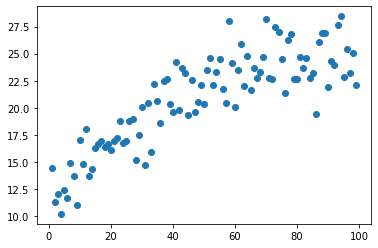

In [ ]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


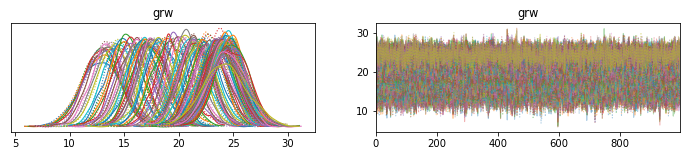

In [ ]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=1.0, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [ ]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([12.96283262, 12.87649487, 12.87200931, 12.9317654 , 13.09666466,
       13.31061416, 13.62854061, 13.86355073, 14.12878442, 14.56192328,
       14.80692839, 15.10070578, 15.22853008, 15.45509308, 15.74759105,
       16.01501615, 16.23096256, 16.37031647, 16.54518056, 16.7037843 ,
       16.88881998, 17.08333882, 17.25773073, 17.3881076 , 17.55230651,
       17.70361339, 17.82082436, 17.87197521, 18.09634664, 18.32552304,
       18.47996419, 18.84552632, 19.10420886, 19.50813054, 19.81736657,
       20.08967406, 20.42018009, 20.67653415, 20.85481502, 21.04493126,
       21.2845626 , 21.36708233, 21.503471  , 21.5391999 , 21.47513569,
       21.57385209, 21.58263629, 21.76409274, 21.96790648, 22.13155159,
       22.39656176, 22.60797481, 22.67380574, 22.81437182, 22.91009942,
       22.9816848 , 23.08390706, 23.3634474 , 23.33808929, 23.30688997,
       23.41309342, 23.53777654, 23.57224989, 23.66060201, 23.67235558,
       23.76653058, 23.8913449 , 24.06741574, 24.26429503, 24.47204074,
       24.4222464 , 24.49218355, 24.62599519, 24.62391297, 24.50538341,
       24.37732932, 24.45467317, 24.3833215 , 24.21691244, 24.15537644,
       24.1132104 , 24.03967724, 24.0319819 , 23.96809173, 23.96282004,
       24.01690226, 24.29069298, 24.49980944, 24.58398844, 24.55922925,
       24.60309101, 24.73905558, 24.90602798, 24.90749485, 24.6961131 ,
       24.59768991, 24.47650008, 24.36388796, 24.26032796])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

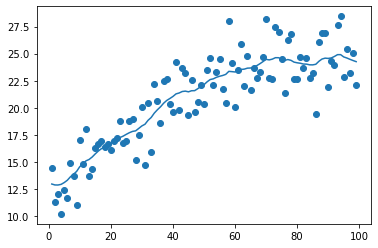

In [ ]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [ ]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [ ]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


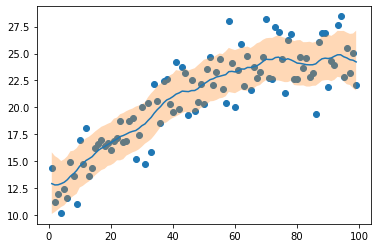

In [ ]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [ ]:
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [ ]:
#YL = raw_df.query("partido == 'PT' ")["percentual"]
YL = 100.00 * df.LULA/df.TOTAL
OL = 100.00 * df.OUTROS/df.TOTAL
POLLSTERS = pd.Categorical(df.instituto)
print(POLLSTERS, POLLSTERS.codes)
P = len(POLLSTERS.unique())
print(P)
#print(OL)
#YL = YL.append(to_append=pd.Series([42, 36.9, 44]))
#OL = OL.append(to_append=pd.Series([45, 45, 48, 44,45, 44]))
#YL = YL.append(to_append=pd.Series([np.nan]*10))

XL = np.arange(YL.size)
# XL = df_results_weekly.data
# YL = YL.append(to_append=pd.Series([42]))
# YL[10:13]=np.nan

['Vox Populi', 'Quaest', 'Paraná Pesquisas', 'Futura', 'PoderData', ..., 'Ipespe', 'Ideia Big Data', 'PoderData', 'Futura', 'Ipespe']
Length: 20
Categories (11, object): ['Atlas', 'Datafolha', 'Futura', 'Ideia Big Data', ..., 'Paraná Pesquisas', 'PoderData', 'Quaest', 'Vox Populi'] [10  9  7  2  8  0  9  3  6  2  4  1  5  8  9  5  3  8  2  5]
11


In [ ]:
print(POLLSTERS.shape, YL.shape, OL.shape)
PRESUMED_STD = np.sqrt((50**2)/2000)
print(PRESUMED_STD)

(20,) (20,) (20,)
1.118033988749895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [demais, lula, poll_bias, inov]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


13:34:14


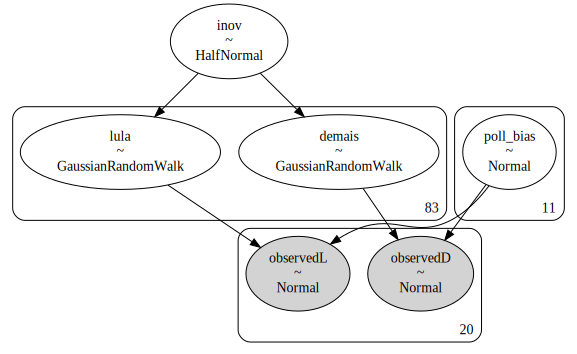

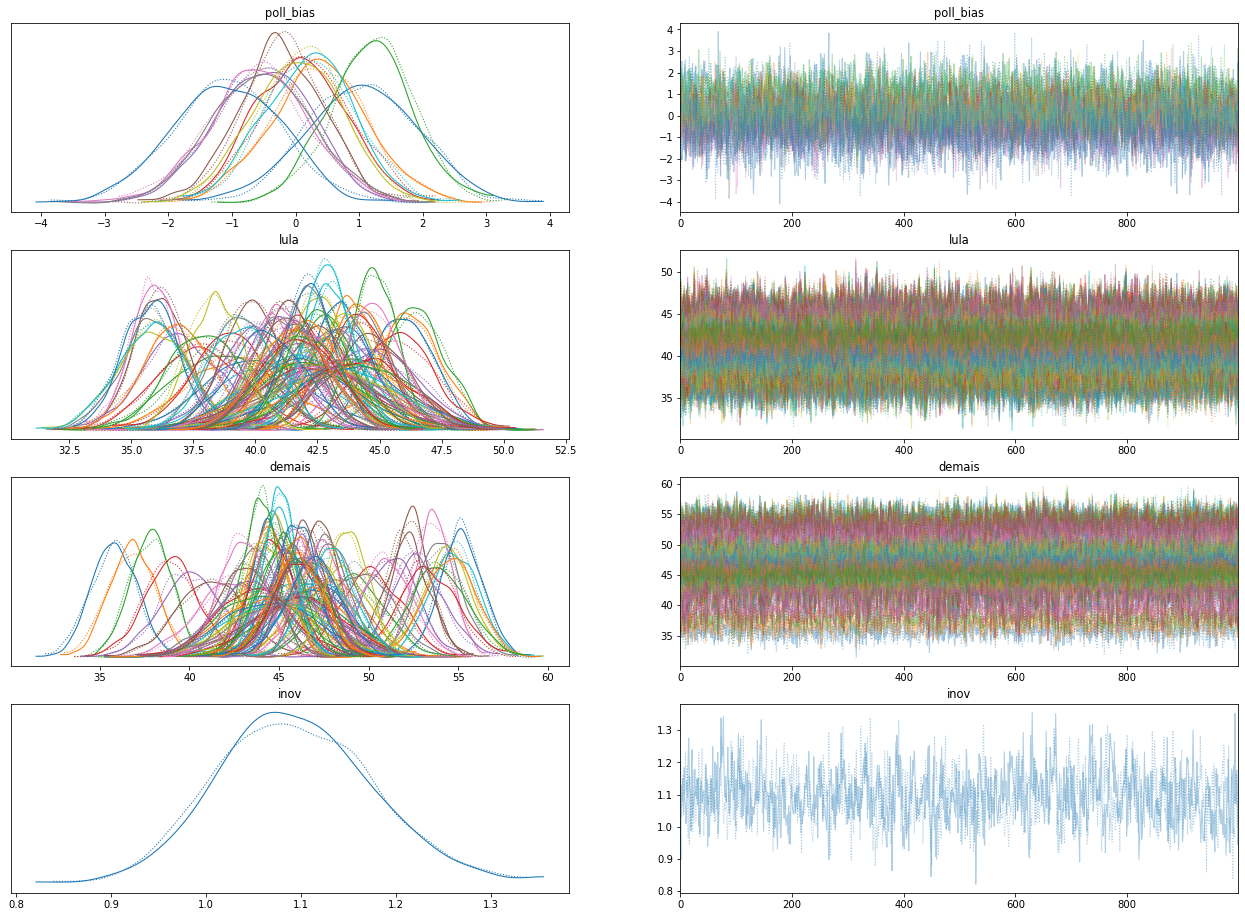

In [ ]:
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=0.15)
    
    #poll_bias = pm.Cauchy("poll_bias", alpha=0, beta=10, shape=P)
    
    #zero_sum_house_bias = pm.Deterministic('zero_sum_poll_bias', var=(poll_bias - poll_bias.mean()))
    poll_bias = pm.Normal("poll_bias", 0, 1.00, shape=P)
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    #sigma = pm.HalfCauchy("sigma", beta=10)
    

    pm.Normal('observedL', mu=grw_lula[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=YL)
    pm.Normal('observedD', mu=grw_demais[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=OL)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [ ]:
print(trace.posterior.lula.mean(axis=0).shape)
print(trace.posterior.demais.mean(axis=0).shape)

(1000, 83)
(1000, 83)


In [ ]:
poll_day.values

array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82])

In [ ]:
datas = []
print(n_days)
for d in range(n_days):
    datas.append((pd.to_datetime(df.data_pesquisa).min() + pd.Timedelta(days=d)).strftime("%Y-%m-%d"))

83


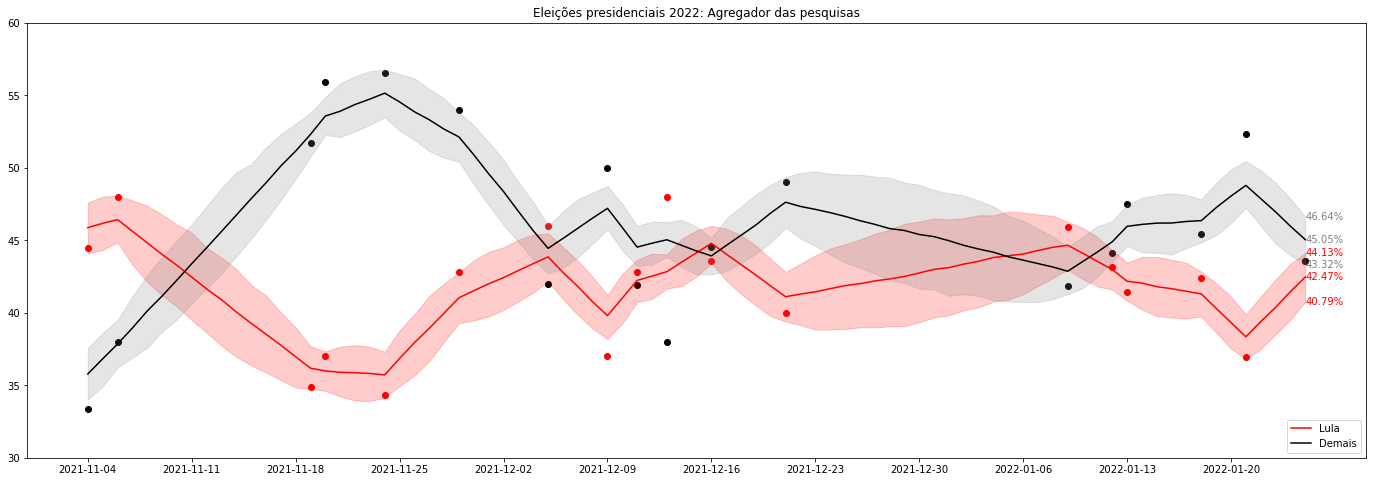

In [ ]:
qsL = np.quantile(trace.posterior.lula.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.demais.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

In [ ]:
df_results_weekly['LULA'] = df.LULA.values
df_results_weekly['DEMAIS'] = df.OUTROS.values
df_results_weekly['TOTAL'] = df.TOTAL.values

df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB,LULA,DEMAIS,TOTAL
0,2021-11-04,0.389886,0.415152,0.439394,0.399495,0.424242,0.450505,880.000,660.000,1980.0
0,2021-11-06,0.409025,0.432314,0.456089,0.389131,0.412906,0.436196,990.240,783.940,2063.0
0,2021-11-19,0.389495,0.412785,0.438057,0.413280,0.437562,0.461348,704.980,1044.340,2020.0
0,2021-11-20,0.378500,0.402500,0.427012,0.440500,0.465500,0.489500,740.000,1118.000,2000.0
0,2021-11-24,0.364040,0.385859,0.408081,0.470707,0.493333,0.515960,850.000,1400.000,2475.0
0,2021-11-29,0.384860,0.401682,0.418732,0.493521,0.511025,0.527847,1883.628,2376.540,4401.0
0,2021-12-05,0.387033,0.409627,0.432711,0.475442,0.498527,0.520629,937.020,855.540,2037.0
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.498333,0.528333,444.000,600.000,1200.0
0,2021-12-11,0.387500,0.412000,0.437000,0.447000,0.473000,0.498500,856.856,838.838,2002.0
0,2021-12-13,0.380000,0.404000,0.427500,0.464500,0.488500,0.513000,758.000,1072.000,2000.0


In [ ]:
# YL = YL/100.0
# dfrw.data.values[-1]


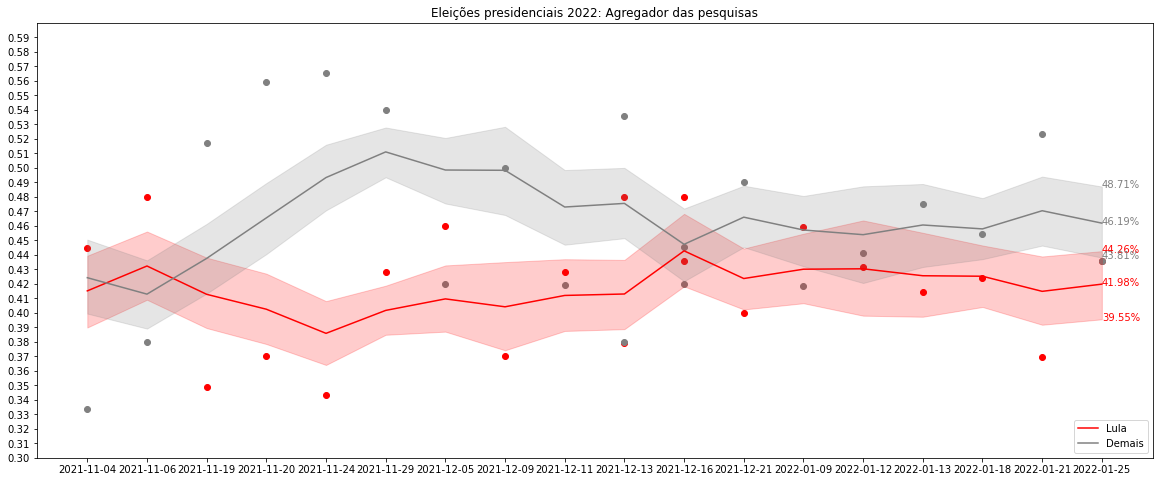

In [ ]:
dfrw = df_results_weekly.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(df.data_pesquisa, df.LULA/df.TOTAL, color='red')
plt.scatter(df.data_pesquisa, df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

In [ ]:

blabla

NameError: name 'blabla' is not defined

### Machine Learning

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)

In [ ]:
print(f'{day_zero=}')
print(f'{n_days=}')
print(f'{poll_day.values=}')

day_zero=Timestamp('2021-11-04 00:00:00')
n_days=83
poll_day.values=array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82])


In [ ]:
svr = SVR(kernel='rbf', C=50, gamma=1e-3, epsilon=0.1)
Y = 100* df.LULA/df.TOTAL
print(poll_day.shape, Y.shape)

(20,) (20,)


In [ ]:
svr.fit(poll_day.values.reshape(-1,1), Y, sample_weight=df.TOTAL/2000.0)

SVR(C=50, gamma=0.001)

In [ ]:
pred_lula = svr.predict(np.arange(0,85).reshape(-1,1))

In [ ]:
pred_lula

array([44.34458553, 43.62777197, 42.9275982 , 42.24977388, 41.59980192,
       40.98290425, 40.40395068, 39.86739205, 39.37719905, 38.93680766,
       38.54907242, 38.21622824, 37.93986163, 37.72089179, 37.55956211,
       37.45544202, 37.4074394 , 37.41382322, 37.47225598, 37.57983534,
       37.73314428, 37.92830857, 38.16106081, 38.42680953, 38.72071222,
       39.0377509 , 39.37280886, 39.72074715, 40.07647947, 40.43504418,
       40.79167221, 41.14184975, 41.48137475, 41.80640644, 42.11350711,
       42.3996758 , 42.66237344, 42.89953949, 43.10959989, 43.29146681,
       43.44453033, 43.56864276, 43.66409608, 43.73159343, 43.77221537,
       43.78738179, 43.77881058, 43.74847378, 43.69855237, 43.63139049,
       43.54945007, 43.45526652, 43.35140645, 43.24042779, 43.12484309,
       43.00708629, 42.88948328, 42.77422664, 42.66335442, 42.55873318,
       42.46204514, 42.37477927, 42.29822609, 42.23347596, 42.18142044,
       42.14275639, 42.11799252, 42.10745775, 42.11131132, 42.12

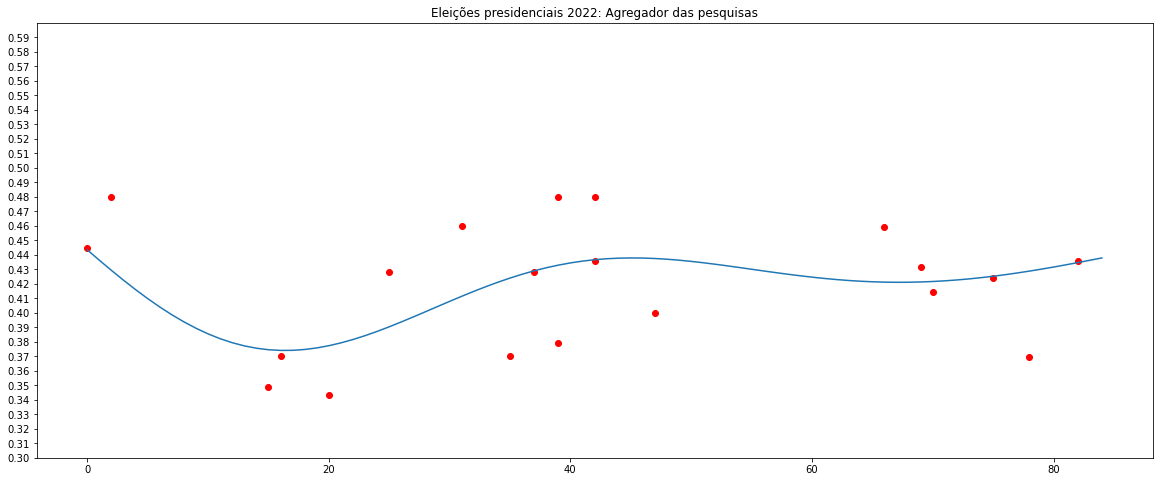

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,85), pred_lula/100.)

In [ ]:
from sklearn.model_selection import GridSearchCV
svr = SVR()
parameters = {'C': np.arange(500, 2000, 50), 'gamma': np.arange(1e-05, 1.1e-3, 1e-5)}

In [ ]:
clf = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error', cv=poll_day.values.size//1, verbose=1)
clf.fit(poll_day.values.reshape(-1,1), Y, sample_weight=np.sqrt(df.TOTAL/df.TOTAL.min()))

Fitting 20 folds for each of 3270 candidates, totalling 65400 fits


KeyboardInterrupt: 

In [ ]:
clf.best_params_

{'C': 1850, 'gamma': 8e-05}

In [ ]:
np.arange(1e-3, 1e-1, 5e-3)

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096])

In [ ]:
pred_lula = clf.best_estimator_.predict(np.arange(0,n_days).reshape(-1,1))

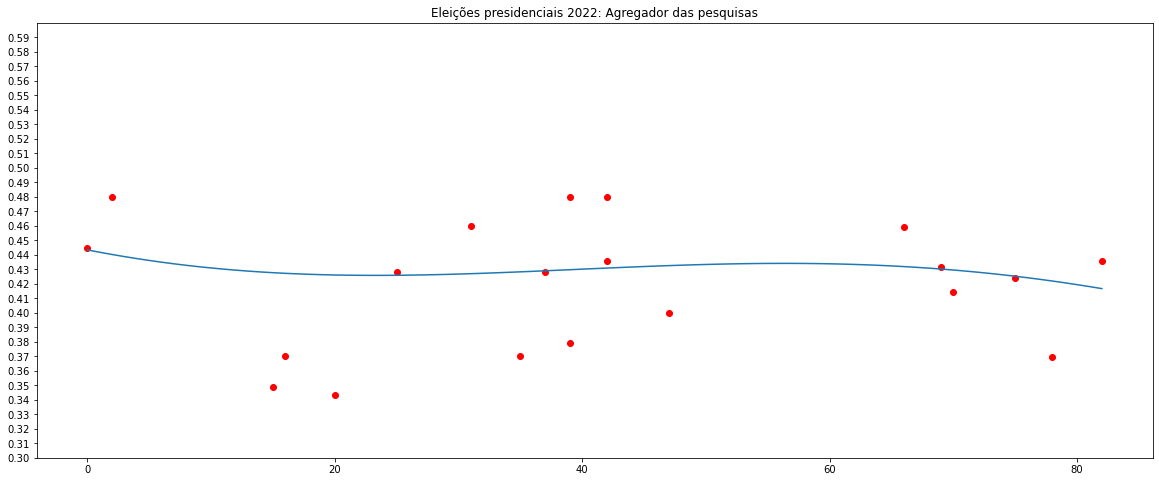

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), pred_lula/100.)

In [ ]:
res = []
svr = SVR(C=1600, gamma=7.000000000000001e-05)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = df.TOTAL/df.TOTAL.min()
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    svr.fit(poll_day.iloc[idx].values.reshape(-1,1), Y.iloc[idx].values, sample_weight=sw.iloc[idx].values)
    res.append(svr.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

(10000, 83)


In [ ]:
qs = np.quantile(res, q=[0.025, 0.2, 0.5, 0.8, 0.975], axis=0)
qs.shape

(5, 83)

Text(82, 33.90126527426761, '34.15%')

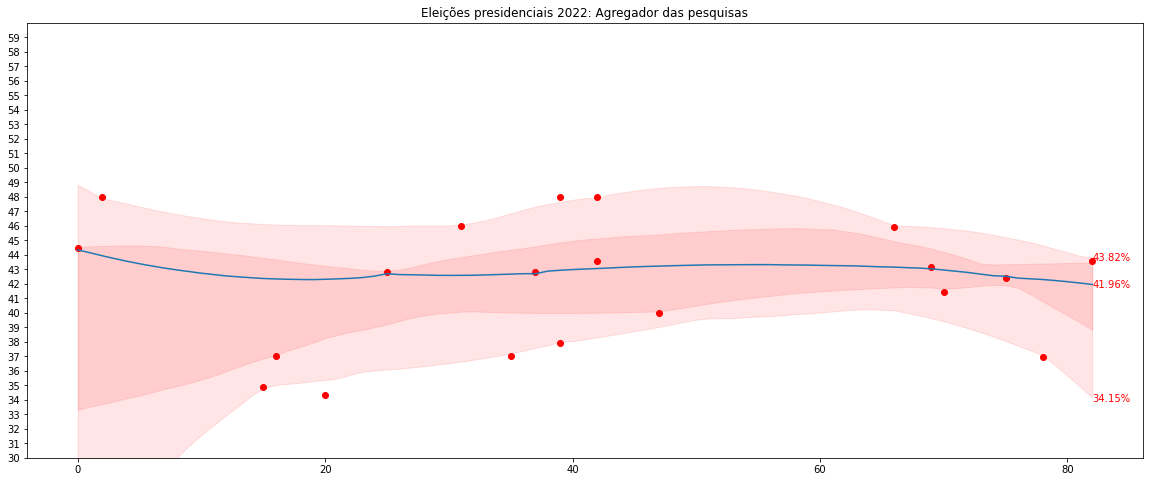

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(30, 60)
plt.yticks(np.arange(30, 60, 1))
plt.scatter(poll_day, 100*df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), qs[2])
plt.fill_between(x=np.arange(0,n_days), y1=qs[0], y2=qs[4], alpha=0.1, color='red')
plt.fill_between(x=np.arange(0,n_days), y1=qs[1], y2=qs[3], alpha=0.1, color='red')
plt.text(n_days-1, qs[4][-1]-.25, f'{qs[4][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[2][-1]-.25, f'{qs[2][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[0][-1]-.25, f'{qs[0][-1]:.2f}%', color='red')


In [ ]:
from sklearn.neural_network import MLPClassifier

res = []
rf = RandomForestClassifier(n_estimators=100)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = np.sqrt(df.TOTAL/df.TOTAL.min())
Y = np.array([df.LULA/df.TOTAL, df.OUTROS/df.TOTAL, df.NULO/df.TOTAL]).T
print(Y.shape)
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    rf.fit(poll_day.iloc[idx].values.reshape(-1,1), Y[idx], sample_weight=sw.iloc[idx].values)
    res.append(rf.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

NameError: name 'RandomForestClassifier' is not defined

## Multinomial Logistic Regression with custom loss function

In [ ]:
def linear(x, betas):
    return np.dot(x, np.array(betas).reshape(x.shape[1], -1))

def multinomial(z):
    return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

def costJ(X, y, theta, C, weight=None):
    m = y.shape[0]
    if weight is None:
        weight = np.repeat(1.0, m).reshape(m,1)
    else:
        weight = weight.reshape(m,1)
    res = np.abs(y - multinomial(linear(X, theta)))
    regul = np.sum(weight * C * np.sum(theta**2))
    return 1./m * (np.sum((10*res)**2) + regul)
    #return 1./m * np.sum(-np.log(1. - res + 1e-6) + regul)
    # return np.sum(-np.log(1.0 - res + 1e-6))
    

In [ ]:
x = np.hstack([np.ones((10,1)), np.ones((10,1)) * np.arange(10).reshape(10,-1)])
betas = np.random.randn(2,3)
x, betas

(array([[1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 4.],
        [1., 5.],
        [1., 6.],
        [1., 7.],
        [1., 8.],
        [1., 9.]]),
 array([[ 0.06662019,  1.70338268,  0.52718972],
        [-0.19594443, -0.6682728 , -0.86835368]]))

In [ ]:
linear(x, betas)

array([[ 0.06662019,  1.70338268,  0.52718972],
       [-0.12932424,  1.03510987, -0.34116396],
       [-0.32526867,  0.36683707, -1.20951764],
       [-0.5212131 , -0.30143573, -2.07787132],
       [-0.71715753, -0.96970853, -2.946225  ],
       [-0.91310196, -1.63798134, -3.81457868],
       [-1.1090464 , -2.30625414, -4.68293236],
       [-1.30499083, -2.97452694, -5.55128604],
       [-1.50093526, -3.64279974, -6.41963972],
       [-1.69687969, -4.31107255, -7.2879934 ]])

In [ ]:
multinomial(linear(x,betas))

array([[0.12947526, 0.6653095 , 0.20521524],
       [0.19947325, 0.63913407, 0.16139268],
       [0.2931741 , 0.58573788, 0.12108801],
       [0.40706024, 0.50711539, 0.08582437],
       [0.53066012, 0.41222559, 0.05711429],
       [0.64963538, 0.31467233, 0.03569228],
       [0.75183275, 0.22708086, 0.02108639],
       [0.83149601, 0.15659931, 0.01190468],
       [0.88909099, 0.10441101, 0.006498  ],
       [0.92854154, 0.06799419, 0.00346427]])

In [ ]:
pred = multinomial(linear(x, betas))
costJ(x, pred+0.05, betas, 1.0, np.arange(1,11))

25.075953600609374

In [ ]:
truth = np.random.dirichlet(alpha=[440, 120, 440], size=2)
truth = truth.mean(axis=0) - (np.arange(1,11).reshape(10,1)*0.001) + np.random.randn(10,3)*0.01
truth = truth/truth.sum(axis=1).reshape(-1,1)
print(truth)

[[0.44172447 0.11016861 0.44810692]
 [0.44064997 0.11678921 0.44256083]
 [0.44766108 0.10758494 0.44475397]
 [0.43146566 0.10373322 0.46480112]
 [0.42004006 0.11867263 0.46128731]
 [0.43901605 0.11270238 0.44828157]
 [0.4227177  0.12398631 0.45329599]
 [0.44089398 0.09828909 0.46081693]
 [0.43881056 0.12286055 0.43832889]
 [0.44301486 0.09529522 0.46168992]]


In [ ]:

opt = lambda bs: costJ(x, truth, bs, 0.05, np.arange(10,0, -1)) 
 

In [ ]:
import scipy as sp
found = False
res = sp.optimize.minimize(opt, np.random.randn(6), method='BFGS', options={'gtol': 1e-6})
print(res.success)


True


In [ ]:
computed_betas = res.x

In [ ]:
multinomial(linear(x, computed_betas))

array([[0.41896316, 0.15094286, 0.43009398],
       [0.42222218, 0.1434359 , 0.43434192],
       [0.42531914, 0.13624224, 0.43843862],
       [0.42825803, 0.12935477, 0.44238721],
       [0.43104306, 0.12276587, 0.44619107],
       [0.43367862, 0.11646758, 0.44985381],
       [0.43616921, 0.11045162, 0.45337917],
       [0.43851945, 0.10470948, 0.45677107],
       [0.44073402, 0.09923247, 0.46003352],
       [0.44281764, 0.09401176, 0.4631706 ]])

In [ ]:
truth

array([[0.44172447, 0.11016861, 0.44810692],
       [0.44064997, 0.11678921, 0.44256083],
       [0.44766108, 0.10758494, 0.44475397],
       [0.43146566, 0.10373322, 0.46480112],
       [0.42004006, 0.11867263, 0.46128731],
       [0.43901605, 0.11270238, 0.44828157],
       [0.4227177 , 0.12398631, 0.45329599],
       [0.44089398, 0.09828909, 0.46081693],
       [0.43881056, 0.12286055, 0.43832889],
       [0.44301486, 0.09529522, 0.46168992]])